# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="darkgrid")


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf

So now we can read in the data and work on a random forest classifier, since we are working with a categorical target. 

In [2]:
df = pd.read_csv('data/esrb_ratings.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     1895 non-null   object
 1   console                   1895 non-null   int64 
 2   alcohol_reference         1895 non-null   int64 
 3   animated_blood            1895 non-null   int64 
 4   blood                     1895 non-null   int64 
 5   blood_and_gore            1895 non-null   int64 
 6   cartoon_violence          1895 non-null   int64 
 7   crude_humor               1895 non-null   int64 
 8   drug_reference            1895 non-null   int64 
 9   fantasy_violence          1895 non-null   int64 
 10  intense_violence          1895 non-null   int64 
 11  language                  1895 non-null   int64 
 12  lyrics                    1895 non-null   int64 
 13  mature_humor              1895 non-null   int64 
 14  mild_blood              

Select our features and target

In [3]:
features = df.drop(['title', 'console', 'esrb_rating'], axis=1)
target = df['esrb_rating']

split data into training and test data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=39)


Now let's initialize our random forest and fit the data. 

In [5]:
model = RandomForestClassifier(n_estimators=100, random_state=39)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=39)

and then let's see how our model works out of the box.

In [6]:
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8839050131926122
Classification Report:
               precision    recall  f1-score   support

           E       0.93      0.99      0.96        82
          ET       0.77      0.89      0.82        84
           M       0.92      0.93      0.93        73
           T       0.93      0.79      0.85       140

    accuracy                           0.88       379
   macro avg       0.89      0.90      0.89       379
weighted avg       0.89      0.88      0.88       379



Some of the classes performed better than the others in terms of recall and precision. Let's take a look at this.

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

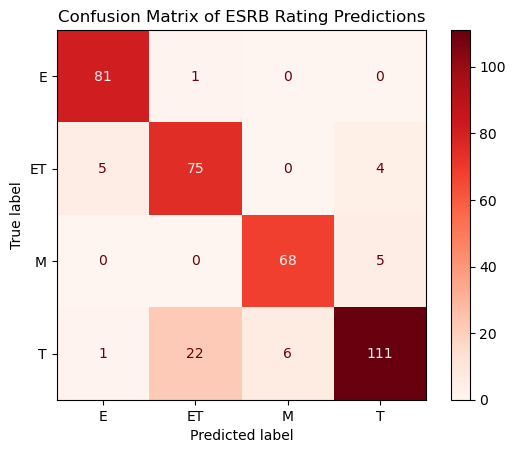

In [8]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot the confusion matrix
graph = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
graph.plot(cmap=plt.cm.Reds)

# Set title and show plot
plt.title("Confusion Matrix of ESRB Rating Predictions")
plt.show()

Let's try and improve on this model. We can start with checking out feature importance, since we have around 30 features.

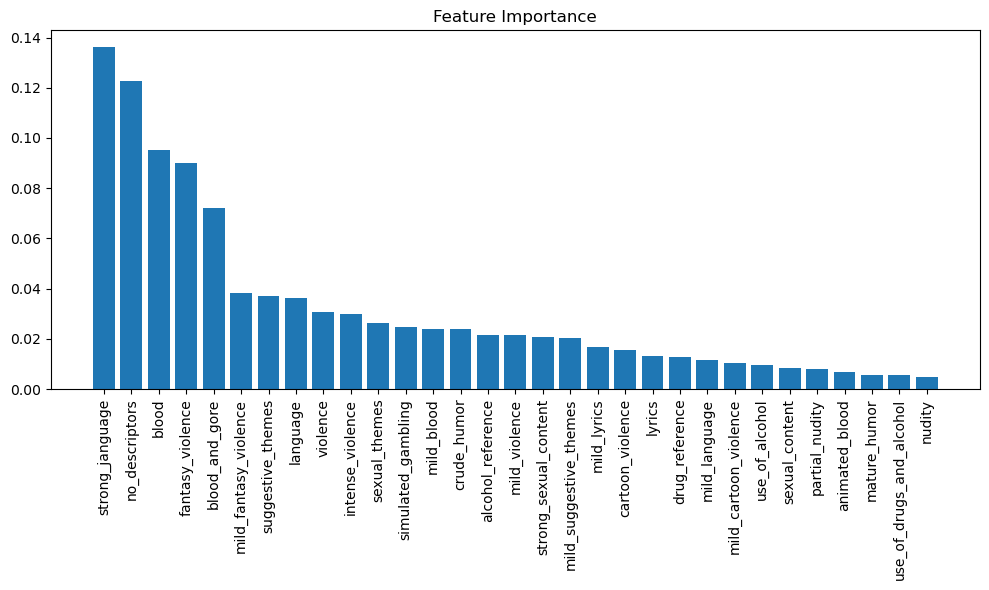

In [9]:
importances = model.feature_importances_
feature_names = features.columns
sorted_indices = importances.argsort()[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.xticks(range(len(sorted_indices)), feature_names[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

Let's try dropping all features that fall belove 0.01

In [10]:
# # Create a mask for features with importance greater than or equal to 0.01
# mask = importances >= 0.01

# # Filter the features based on the mask
# important_features = feature_names[mask]

# # Drop the features with importance below 0.01 from the dataset
# X_train_reduced = X_train[important_features]
# X_test_reduced = X_test[important_features]

In [11]:
# model.fit(X_train_reduced, y_train)

# y_pred = model.predict(X_test_reduced)

# # Evaluate the model
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

Our accuracy dropped from that. Let's forgo that and work on another path. We can try a GridSearch

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [13]:
y_grid_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_grid_pred))
print("Classification Report:\n", classification_report(y_test, y_grid_pred))

Accuracy: 0.8839050131926122
Classification Report:
               precision    recall  f1-score   support

           E       0.93      0.99      0.96        82
          ET       0.77      0.89      0.82        84
           M       0.92      0.93      0.93        73
           T       0.93      0.79      0.85       140

    accuracy                           0.88       379
   macro avg       0.89      0.90      0.89       379
weighted avg       0.89      0.88      0.88       379



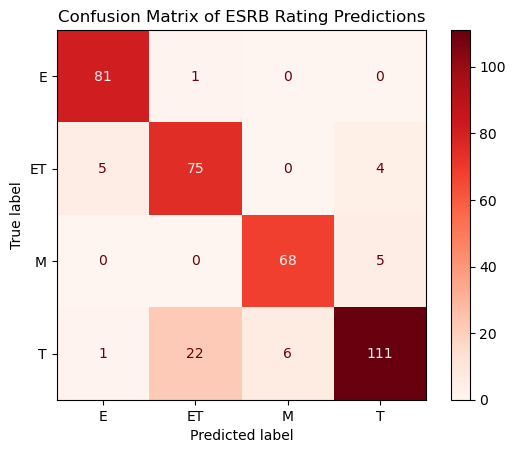

In [14]:
# Generate the confusion matrix
gridCM = confusion_matrix(y_test, y_grid_pred, labels=model.classes_)

# Plot the confusion matrix
graph = ConfusionMatrixDisplay(confusion_matrix=gridCM, display_labels=model.classes_)
graph.plot(cmap=plt.cm.Reds)

# Set title and show plot
plt.title("Confusion Matrix of ESRB Rating Predictions")
plt.show()

We got the exact same numbers. Maybe XGBClassifier will yield improvements?

In [15]:
# !pip install xgboost

We need to encode our target since XGBclassifier is looking for numeric data.

In [16]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode the ESRB ratings as numeric values
le = LabelEncoder()
y_encoded = le.fit_transform(target)  # Convert 'E', 'T', etc. to numbers

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, random_state=39)

xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

In [17]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

Accuracy: 0.8812664907651715
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96        82
           1       0.77      0.87      0.82        84
           2       0.94      0.90      0.92        73
           3       0.90      0.81      0.85       140

    accuracy                           0.88       379
   macro avg       0.88      0.89      0.89       379
weighted avg       0.88      0.88      0.88       379



Accuracy dropped a bit, it looks like the precision and recall may have improved?

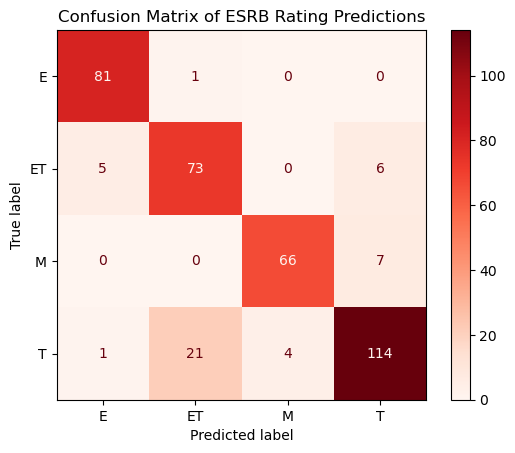

In [18]:
# Generate the confusion matrix
xgbCM = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
graph = ConfusionMatrixDisplay(confusion_matrix=xgbCM, display_labels=model.classes_)
graph.plot(cmap=plt.cm.Reds)

# Set title and show plot
plt.title("Confusion Matrix of ESRB Rating Predictions")
plt.show()

Available metrics: odict_keys(['mlogloss'])


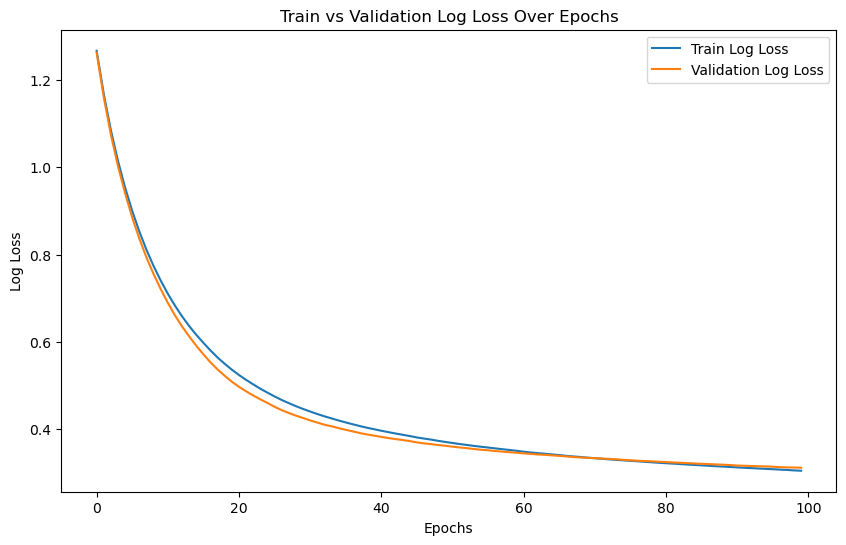

In [19]:
# Define the evaluation set (training and validation data)
eval_set = [(X_train, y_train), (X_test, y_test)]

# Train the model and track performance
xgb_clf.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Retrieve performance metrics
results = xgb_clf.evals_result()

print('Available metrics:', results['validation_0'].keys())

# Extract logloss for training and validation (assuming mlogloss is available for multi-class)
train_metric = results['validation_0']['mlogloss']  # or use 'logloss' for binary classification
test_metric = results['validation_1']['mlogloss']


# Plot the training and validation metric over epochs
epochs = len(train_metric)
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))

plt.plot(x_axis, train_metric, label='Train Log Loss')
plt.plot(x_axis, test_metric, label='Validation Log Loss')

# Set the plot details
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Train vs Validation Log Loss Over Epochs')
plt.legend()
plt.show()

Doesn't seem to be much in the way of over or underfitting. We aren't getting too much difference. It seems be to dropping as we try more. So let's move onto something more advanced.

_________

## Advanced Machine Learning


______

Let's now try to work on a neural network.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


# Encode the target variable as integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# One-hot encode the target variable for use in categorical cross-entropy
y_train_one_hot = to_categorical(y_train_encoded, num_classes=len(le.classes_))
y_test_one_hot = to_categorical(y_test_encoded, num_classes=len(le.classes_))


model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(le.classes_), activation='softmax'))  # Output layer for classification

# Set a custom learning rate for the Adam optimizer
learning_rate = 0.0001  # You can adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#train model
history = model.fit(X_train, y_train_one_hot, epochs=150, batch_size=32, validation_data=(X_test, y_test_one_hot))

Epoch 1/150
48/48 [==============================] - 1s 7ms/step - loss: 1.3934 - accuracy: 0.3476 - val_loss: 1.3745 - val_accuracy: 0.4749
Epoch 2/150
48/48 [==============================] - 0s 4ms/step - loss: 1.3609 - accuracy: 0.4664 - val_loss: 1.3416 - val_accuracy: 0.5567
Epoch 3/150
48/48 [==============================] - 0s 4ms/step - loss: 1.3290 - accuracy: 0.5059 - val_loss: 1.3088 - val_accuracy: 0.5673
Epoch 4/150
48/48 [==============================] - 0s 4ms/step - loss: 1.2973 - accuracy: 0.5257 - val_loss: 1.2759 - val_accuracy: 0.5646
Epoch 5/150
48/48 [==============================] - 0s 4ms/step - loss: 1.2662 - accuracy: 0.5330 - val_loss: 1.2432 - val_accuracy: 0.5884
Epoch 6/150
48/48 [==============================] - 0s 4ms/step - loss: 1.2343 - accuracy: 0.5501 - val_loss: 1.2088 - val_accuracy: 0.5989
Epoch 7/150
48/48 [==============================] - 0s 4ms/step - loss: 1.2008 - accuracy: 0.6722 - val_loss: 1.1732 - val_accuracy: 0.7414
Epoch 8/150
4

The Numbers look pretty good after 50 epochs. Let's plot this out to check for overfitting.

In [21]:
def plot_ml_acc_loss (history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Show the plots
    plt.tight_layout()
    plt.show()

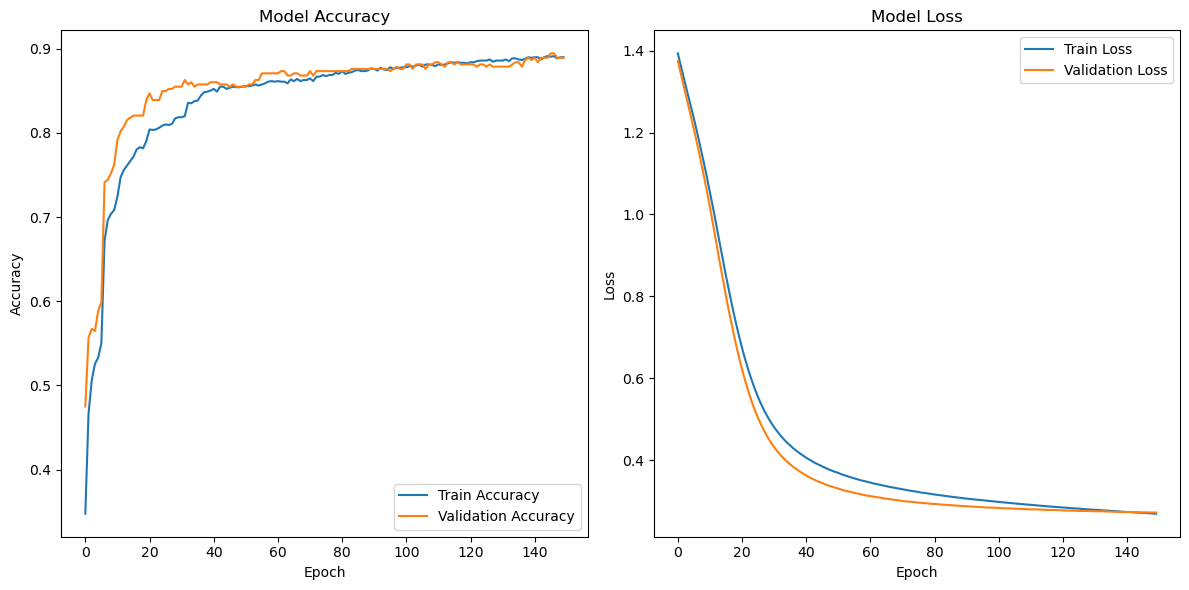

In [22]:
plot_ml_acc_loss(history)

It looks like our model accuracy peaks at around 35 epochs and our model loss plateaus at 20 epochs. Let's work on improving that. (Original run through at 0.001 LR)

Changes to 0.0001 learning rate and the graph above looks much more fluid. 

Let's use EarlyStopping and Reduce Learning Rate to try and help with overfitting

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Add EarlyStopping to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# ReduceLROnPlateau: Reduce the learning rate if validation loss plateaus for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)

# Re-train the model with early stopping
history = model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, 
                    validation_data=(X_test, y_test_one_hot), 
                    callbacks=[early_stopping, reduce_lr])

# After EarlyStopping, the best model will be restored.
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2686 - accuracy: 0.8918 - val_loss: 0.2720 - val_accuracy: 0.8892 - lr: 1.0000e-04
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 0.2682 - accuracy: 0.8912 - val_loss: 0.2718 - val_accuracy: 0.8945 - lr: 1.0000e-04
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 0.2678 - accuracy: 0.8931 - val_loss: 0.2710 - val_accuracy: 0.8945 - lr: 1.0000e-04
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 0.2674 - accuracy: 0.8918 - val_loss: 0.2718 - val_accuracy: 0.8892 - lr: 1.0000e-04
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 0.2670 - accuracy: 0.8925 - val_loss: 0.2710 - val_accuracy: 0.8892 - lr: 1.0000e-04
Epoch 6/100
48/48 [==============================] - 0s 6ms/step - loss: 0.2664 - accuracy: 0.8918 - val_loss: 0.2712 - val_accuracy: 0.8945 - lr: 1.0000e-04
Epoch 7/100
48/48 [==============================] -

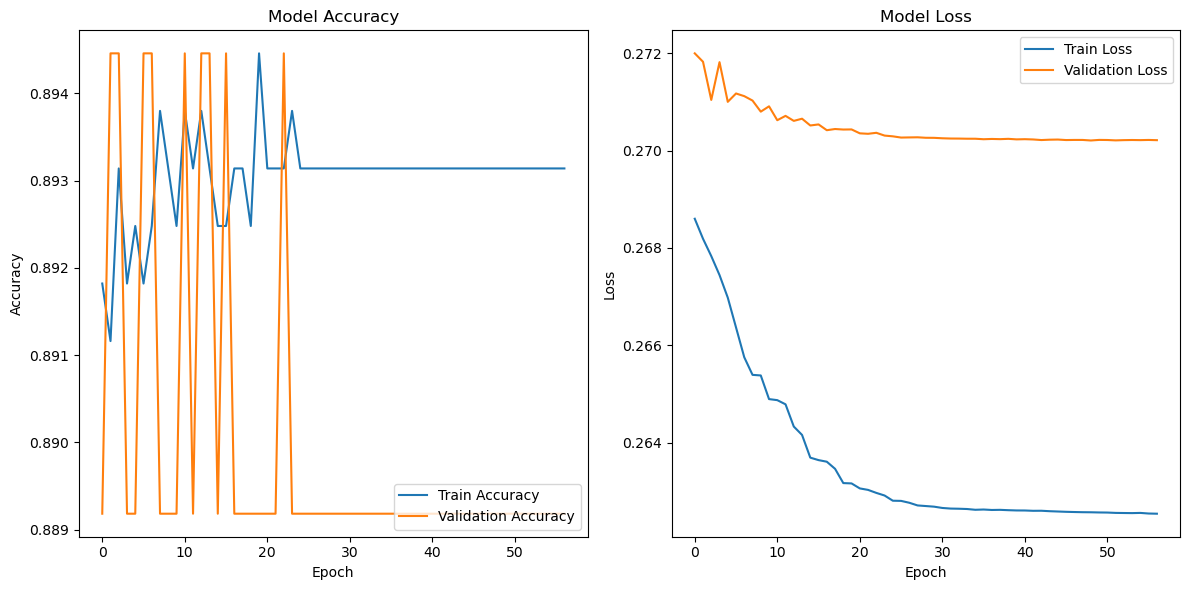

In [24]:
plot_ml_acc_loss(history)